In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

In [2]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display as libd

In [4]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
%matplotlib inline

In [5]:
train_audio_path = 'train/audio/'
filename = 'on/facd97c0_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [6]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    frequency, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                               window='hann', nperseg=nperseg,
                                               noverlap=noverlap, detrend=False)
    return frequency, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
frequencies, times, spectrogram = log_specgram(samples,sample_rate)

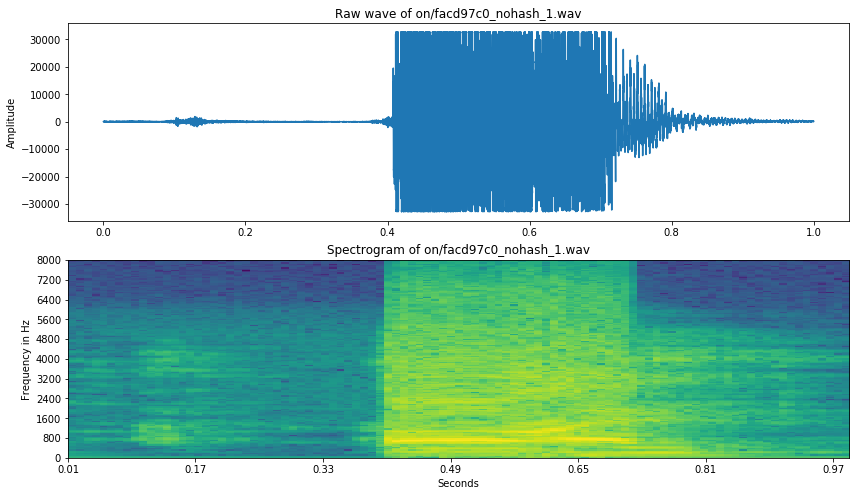

In [9]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0,sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=(times.min(), times.max(), frequencies.min(), frequencies.max()))
ax2.set_yticks(frequencies[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequency in Hz')
ax2.set_xlabel('Seconds')

In [11]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

# MFCC

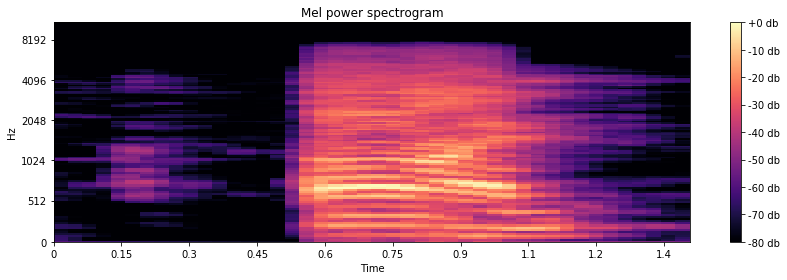

In [14]:
y, sr = librosa.load(str(train_audio_path) + filename)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_s = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
libd.specshow(log_s, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f db')
plt.tight_layout()

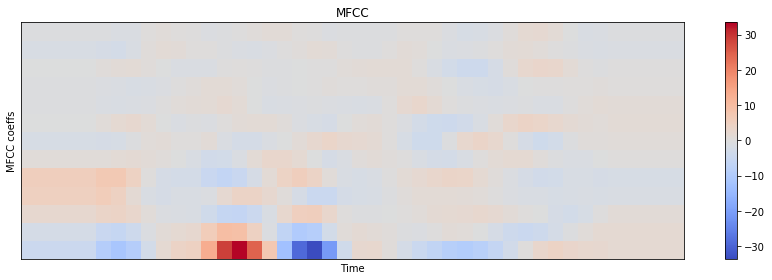

In [17]:
mfcc = librosa.feature.mfcc(S=log_s, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
libd.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# Spectrogram in 3d

In [18]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Spectrogram of "on" in 3d',
    scene=dict(
        yaxis=dict(title='Frequencies',  range=frequencies),
        xaxis=dict(title='Time',  range=times),
        zaxis=dict(title='Log AMplitude')
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Silence Removal

In [19]:
ipd.Audio(samples, rate=sample_rate)

In [20]:
samples_out = samples[4000:13000]
ipd.Audio(samples_out, rate=sample_rate)

In [21]:
freqs, times, spectrogram_out = log_specgram(samples_out, sample_rate)

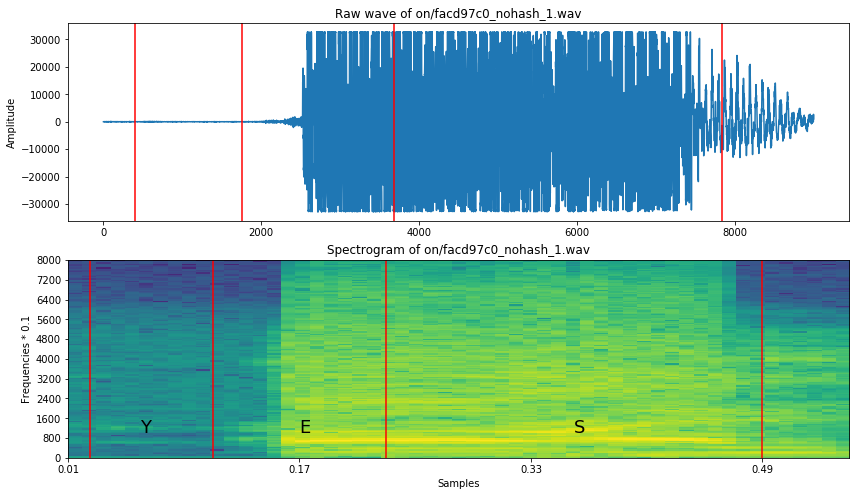

In [22]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_out)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.imshow(spectrogram_out.T, aspect='auto', origin='lower',
          extent=(times.min(), times.max(), freqs.min(), freqs.max()))
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## Resampling - dimensionality reduction

In [23]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

In [24]:
filename = 'happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [25]:
ipd.Audio(samples, rate=sample_rate)

In [26]:
ipd.Audio(resampled, rate=new_sample_rate)

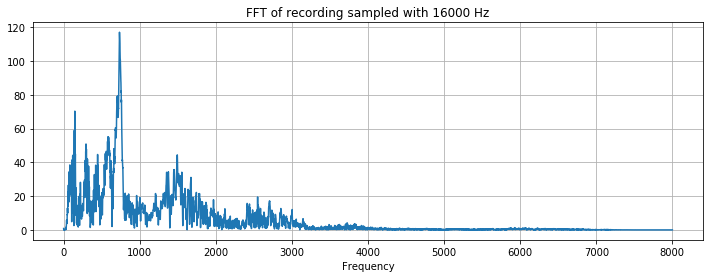

In [27]:
xf, vals = custom_fft(samples, sample_rate)

plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

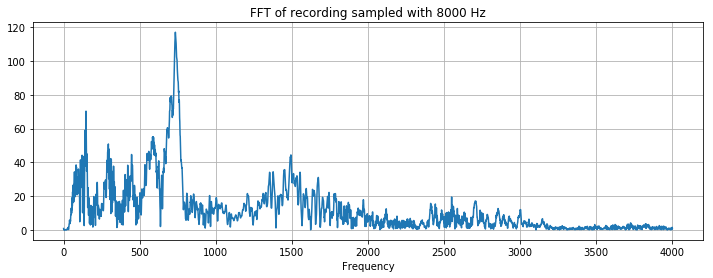

In [28]:
xf, vals = custom_fft(resampled, new_sample_rate)

plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

Inspiration: https://www.kaggle.com/davids1992/speech-representation-and-data-exploration